## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Dataset

In [2]:
df = pd.read_csv("Social_Network_Ads.csv")

In [3]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
User ID            400 non-null int64
Gender             400 non-null object
Age                400 non-null int64
EstimatedSalary    400 non-null int64
Purchased          400 non-null int64
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


## Splitting dataset

In [5]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Statistics

In [7]:
qualitative = [column for column in X.columns if X[column].dtype=="object"]
quantitative = [column for column in X.columns if column not in qualitative]

In [8]:
X_train[quantitative].describe()

,Age,EstimatedSalary
count,300.000000,300.000000
mean,38.126667,69583.333333
std,10.114592,34548.541619
min,18.000000,15000.000000
25%,30.750000,43000.000000
50%,38.000000,69500.000000
75%,46.000000,88000.000000
max,60.000000,150000.000000


In [9]:
X_train[qualitative].describe()

,Gender
count,300
unique,2
top,Female
freq,153


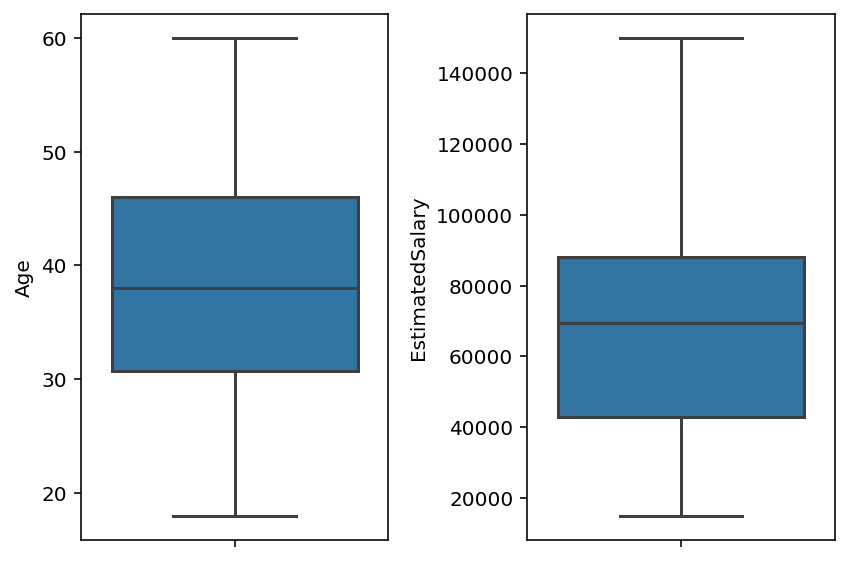

In [10]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.boxplot(y=quantitative[2*i+j], data=X_train, ax=ax[i][j])
        except:
            sns.boxplot(y=quantitative[2*i+j], data=X_train, ax=ax[j])
plt.tight_layout()
plt.show()

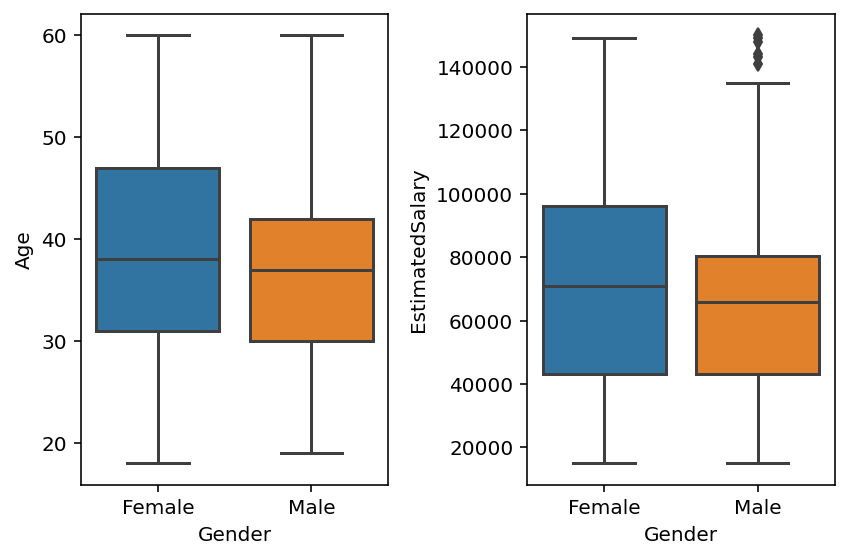

In [11]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.boxplot(x="Gender", y=quantitative[2*i+j], data=X_train, ax=ax[i][j])
        except:
            sns.boxplot(x="Gender", y=quantitative[2*i+j], data=X_train, ax=ax[j])
plt.tight_layout()
plt.show()

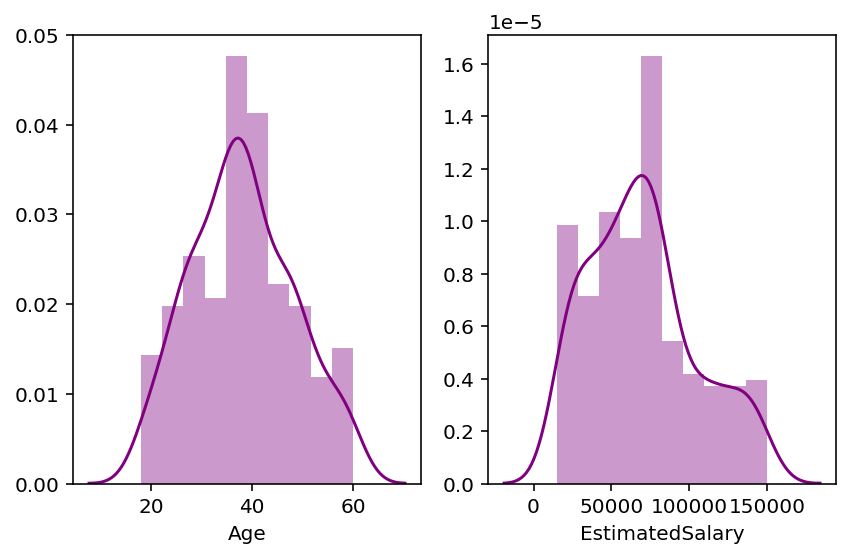

In [12]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.distplot(X_train[quantitative[2*i+j]], color="purple", ax=ax[i][j])
        except:
            sns.distplot(X_train[quantitative[2*i+j]], bins=10, color="purple", ax=ax[j])
plt.tight_layout()
plt.show()

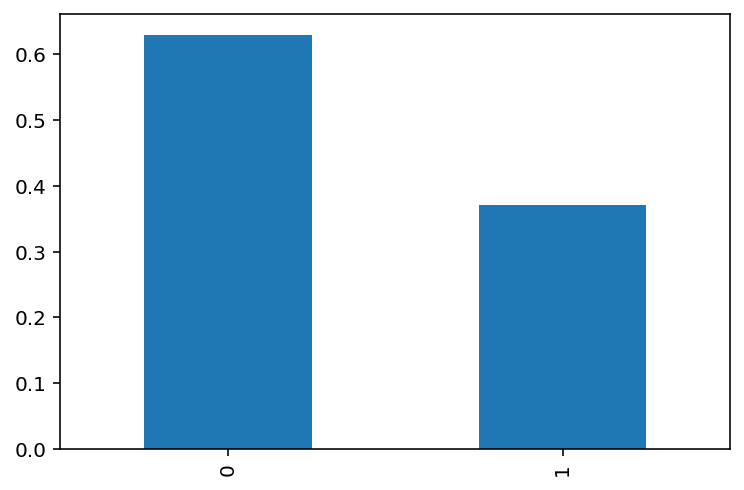

In [13]:
(y_train.value_counts()/y_train.shape).plot(kind="bar")
plt.show()

## Complete Model

In [14]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data):
        assert isinstance(data, pd.DataFrame), "Insert a pandas dataframe."
        
        return data[self.columns]

In [15]:
num_preprocessor = Pipeline(steps=[
    ("num_selector", ColumnSelector(columns=quantitative)),
    ("standardization", StandardScaler())])
cat_preprocessor = Pipeline(steps=[
    ("cat_selector", ColumnSelector(columns=qualitative)),
    ("onehot", OneHotEncoder())])
preprocessor = FeatureUnion(transformer_list=[("categorical", cat_preprocessor), ("numerical", num_preprocessor)])

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svm", SVC(C=1.0, kernel="rbf", probability=True, random_state=0))])

In [16]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  ColumnSelector(columns=['Gender'])),
                                                                 ('onehot',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=True))],
     

In [17]:
y_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

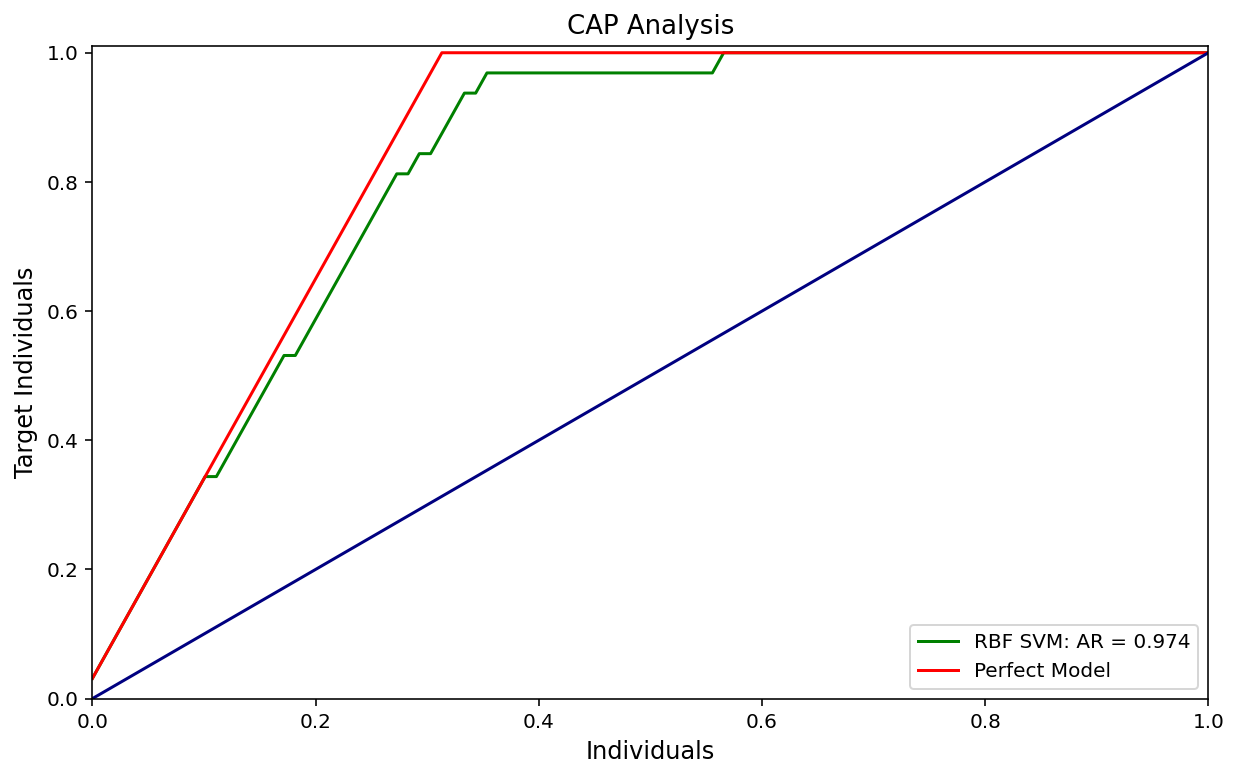

In [18]:
cap_df = pd.DataFrame(data=y_test, index=y_test.index)
cap_df["Probability"] = probabilities

total = cap_df["Purchased"].sum()
perfect_model = (cap_df["Purchased"].sort_values(ascending=False).cumsum()/total).values
current_model = (cap_df.sort_values(by="Probability", ascending=False)["Purchased"].cumsum()/total).values

max_area = 0
covered_area = 0
h = 1/len(current_model)
for i, (am, ap) in enumerate(zip(current_model, perfect_model)):
    try:
        max_area += (ap+perfect_model[i+1])*h/2
        covered_area += (am+current_model[i+1])*h/2
    except:
        continue
accuracy_rate = covered_area/max_area

fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(np.linspace(0, 1, len(current_model)), current_model, 
                     color="green", label=f"RBF SVM: AR = {accuracy_rate:.3f}")
plt.plot(np.linspace(0, 1, len(perfect_model)), perfect_model, color="red", label="Perfect Model")
plt.plot([0,1], [0,1], color="navy")
plt.xlabel("Individuals", fontsize=12)
plt.ylabel("Target Individuals", fontsize=12)
plt.xlim((0,1))
plt.ylim((0,1.01))
plt.legend(loc=4, fontsize=10)
plt.title("CAP Analysis", fontsize=13)
plt.show()